In [20]:
import sys
sys.path.append('C:/Users/Nishant Joshi/Model_fitting/GIFFittingToolbox/src')
from Experiment import *
from AEC_Badel import *
from GIF import *
from Filter_Rect_LogSpaced import *
from Filter_Rect_LinSpaced import *
import pickle
import matplotlib.pyplot as plt
from Filter_Exps import * 


In [21]:

def get_gamma_factor(model, data, delta, time, dt, rate_correction=True):
    """
    Calculate gamma factor between model and target spike trains,
    with precision delta.

    Parameters
    ----------
    model: `list` or `~numpy.ndarray`
        model trace
    data: `list` or `~numpy.ndarray`
        data trace
    delta: `~brian2.units.fundamentalunits.Quantity`
        time window
    dt: `~brian2.units.fundamentalunits.Quantity`
        time step
    time: `~brian2.units.fundamentalunits.Quantity`
        total time of the simulation
    rate_correction: bool
        Whether to include an error term that penalizes differences in firing
        rate, following `Clopath et al., Neurocomputing (2007)
        <https://doi.org/10.1016/j.neucom.2006.10.047>`_.

    Returns
    -------
    float
        An error based on the Gamma factor. If ``rate_correction`` is used,
        then the returned error is :math:`1 + 2\frac{\lvert r_\mathrm{data} - r_\mathrm{model}\rvert}{r_\mathrm{data}} - \Gamma`
        (with :math:`r_\mathrm{data}` and :math:`r_\mathrm{model}` being the
        firing rates in the data/model, and :math:`\Gamma` the coincidence
        factor). Without ``rate_correction``, the error is
        :math:`1 - \Gamma`. Note that the coincidence factor :math:`\Gamma`
        has a maximum value of 1 (when the two spike trains are exactly
        identical) and a value of 0 if there are only as many coincidences
        as expected from two homogeneous Poisson processes of the same rate.
        It can also take negative values if there are fewer coincidences
        than expected by chance.
    """
    model = np.array(model)
    data = np.array(data)

    model = np.array(model / dt, dtype=np.int32)
    data = np.array(data / dt, dtype=np.int32)
    delta_diff = int(np.int32(delta / dt))

    model_length = len(model)
    data_length = len(data)
    # data_rate = firing_rate(data) * Hz
    data_rate = data_length / time
    model_rate = model_length / time

    if model_length > 1:
        bins = .5 * (model[1:] + model[:-1])
        indices = np.digitize(data, bins)
        diff = abs(data - model[indices])
        matched_spikes = (diff <= delta_diff)
        coincidences = sum(matched_spikes)
    elif model_length == 0:
        coincidences = 0
    else:
        indices = [np.amin(abs(model - data[i])) <= delta_diff for i in np.arange(data_length)]
        coincidences = sum(indices)

    # Normalization of the coincidences count
    NCoincAvg = 2 * data_rate * delta * model_length  #2*v2*p*N1
    norm = .5*(1 - 2 * max(data_rate,model_rate) * delta)
    gamma = (coincidences - NCoincAvg)/(norm*(model_length + data_length))

    if rate_correction:
        rate_term = 1 + 2*abs((data_rate - model_rate)/data_rate)
    else:
        rate_term = 1
    return gamma
    # return np.clip(rate_term - gamma, 0, np.inf)


<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
C:\Users\Nishant Joshi\AppData\Local\Temp\ipykernel_15004\4186876461.py:2: SyntaxWarning: invalid escape sequence '\l'
  """


In [67]:
"""
This file shows how to fit a GIF to some experimental data.
More instructions are provided on the website. 
"""
############################################################################################################
# STEP 1: LOAD EXPERIMENTAL DATA
############################################################################################################
myExp = Experiment('Experiment 1', 0.05)

#Inhibitory
with open("G:/My Drive/Bernstein/170725_NC_82_INH.pickle",'rb') as f:
    data = pickle.load(f)
I_data = data['I'][:120*20000]
V_data = data['V'][:120*20000]
spikes_data = data['spikes']    

# #Excitatory
# with open("G:/My Drive/Bernstein/170815_NC_109_EXC.pickle",'rb') as f:
#     data = pickle.load(f)
# I_data = data['I'][:120*20000]
# V_data = data['V'][:120*20000]
# spikes_data = data['spikes']    

# Load AEC data
myExp.setAECTrace(V_data[:int(10*20000)],1e-3,I_data[:int(10*20000)] ,1e-12, 10000.0, FILETYPE='Array')

# Load training set data
myExp.addTrainingSetTrace(V_data,1e-3,I_data, 1e-12, 120000.0, FILETYPE='Array')


Create a new Experiment
Set AEC trace...
Add Training Set trace...


## Perform AEC


PERFORM ACTIVE ELECTRODE COMPENSATION (Badel method)...

Estimate electrode properties...
Repetition  1  R_e (MOhm) = 31.41
Repetition  2  R_e (MOhm) = 31.85
Repetition  3  R_e (MOhm) = 34.28
Repetition  4  R_e (MOhm) = 34.32
Repetition  5  R_e (MOhm) = 34.22
Repetition  6  R_e (MOhm) = 31.75
Repetition  7  R_e (MOhm) = 27.32
Repetition  8  R_e (MOhm) = 33.80
Repetition  9  R_e (MOhm) = 32.52
Repetition  10  R_e (MOhm) = 30.58
Repetition  11  R_e (MOhm) = 31.40
Repetition  12  R_e (MOhm) = 33.98
Repetition  13  R_e (MOhm) = 28.60
Repetition  14  R_e (MOhm) = 31.81
Repetition  15  R_e (MOhm) = 31.33
Done!

Compensate experiment
AEC trace...
I_tmp (200000,)
F (140,)
Training set...
I_tmp (2400000,)
F (140,)
Test set...
Done!


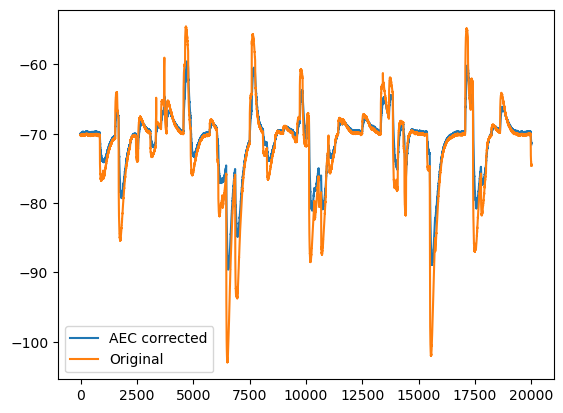

In [3]:
############################################################################################################
# STEP 2: ACTIVE ELECTRODE COMPENSATION
############################################################################################################

# Create new object to perform AEC
myAEC = AEC_Badel(myExp.dt)

# Define metaparametres
myAEC.K_opt.setMetaParameters(length=150.0, binsize_lb=myExp.dt, binsize_ub=2.0, slope=30.0, clamp_period=1.0)
myAEC.p_expFitRange = [3.0,150.0]  
myAEC.p_nbRep = 15     

# Assign myAEC to myExp and compensate the voltage recordings
myExp.setAEC(myAEC)  
myExp.performAEC()  

plt.plot(myExp.trainingset_traces[0].V[:1*20000],label='AEC corrected')
plt.plot(V_data[:1*20000],label='Original')
plt.legend()
plt.show()
# # Plot AEC filters (Kopt and Ke)
# myAEC.plotKopt()
# myAEC.plotKe()

# # Plot training and test set
# myExp.plotTrainingSet()
# myExp.plotTestSet()


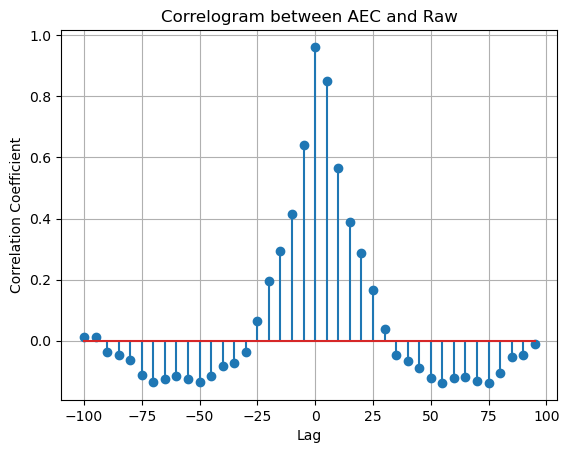

In [4]:
from scipy import signal
def plot_correlations(sig1,sig2,tau,str1,str2,ax):
    signal1 = sig1-np.mean(sig1)
    signal2 = sig2-np.mean(sig2)
    # Calculate cross-correlation with maximum lag of 20
    correlation = signal.correlate(signal1, signal2 , mode='full')
    correlation /= np.sqrt(np.sum(signal1**2)*np.sum(signal2**2))    
    lags = signal.correlation_lags(len(signal1), len(signal1))

    # Plot the correlogram
    # lags = np.arange(-tau,tau,1/20)
    # plt.stem(lags[::100], correlation[len(correlation)//2-tau*20:len(correlation)//2+tau*20][::100])
    ax.stem(lags[len(lags)//2-100*20:len(lags)//2+100*20:100]/20, correlation[len(lags)//2-100*20:len(lags)//2+100*20:100])

    ax.set_xlabel('Lag')
    ax.set_ylabel('Correlation Coefficient')
    ax.set_title(f'Correlogram between {str1} and {str2}')
    ax.grid(True)
    # plt.show()

fig,ax = plt.subplots()
plot_correlations(myExp.trainingset_traces[0].V[:1*20000],V_data[:1*20000],100,'AEC','Raw',ax)

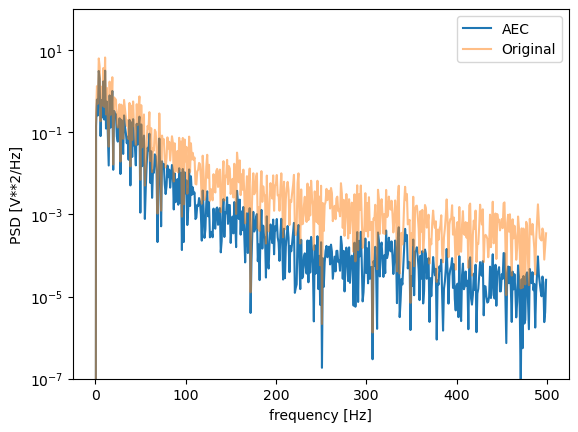

In [25]:
fs = 20000
x = myExp.trainingset_traces[0].V[:1*20000]
f, Pxx_den = signal.periodogram(x, fs)
y = V_data[:1*20000]
f, Pyy_den = signal.periodogram(y, fs)

plt.semilogy(f[:500], Pxx_den[:500],label='AEC')
plt.semilogy(f[:500], Pyy_den[:500],alpha=0.5,label='Original')

plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.legend()
plt.show()

## Fit the data

In [82]:
############################################################################################################
# STEP 3: FIT GIF MODEL TO DATA
############################################################################################################

# Create a new object GIF 
myGIF = GIF(0.05)

# Define parameters
myGIF.Tref = 4.0  

#Rectangular Filter
myGIF.eta = Filter_Rect_LogSpaced()
myGIF.eta.setMetaParameters(length=500.0, binsize_lb=2.0, binsize_ub=1000.0, slope=4.5)

myGIF.gamma = Filter_Rect_LogSpaced()
myGIF.gamma.setMetaParameters(length=10.0, binsize_lb=10.0, binsize_ub=1000.0, slope=10.0)


# Exp Filter
# myGIF.eta = Filter_Exps()
# myGIF.eta.setFilter_Timescales([1.0, 5.0, 30.0, 70.0, 100.0, 500.0])
# myGIF.gamma = Filter_Exps()
# myGIF.gamma.setFilter_Timescales([1.0, 5.0, 30.0, 70.0, 100.0, 500.0])

# Define the ROI of the training set to be used for the fit (in this example we will use only the first 100 s)
myExp.trainingset_traces[0].setROI([[0,100000.0]])

# To visualize the training set and the ROI call again
myExp.detectSpikes_python()
# myExp.plotTrainingSet()





Detect spikes!
Done!


In [83]:
# Perform the fit
myGIF.fit(myExp, DT_beforeSpike=5.0)



################################
# Fit GIF
################################

Estimate voltage reset (Tref = 4.0 ms)...
Done! Vr = -55.30 mV (computed on 365 spikes)

GIF MODEL - Fit subthreshold dynamics...
(2400000, 18)rix for repetition 1

Perform linear regression...

-------------------------
GIF model parameters:
-------------------------
tau_m (ms):	3.391
R (MOhm):	119.402
C (nF):		0.028
gl (nS):	0.008375
El (mV):	-52.252
Tref (ms):	4.000
Vr (mV):	-55.299
Vt* (mV):	-48.000
DV (mV):	0.500
-------------------------

Percentage of variance explained (on dV/dt): 18.48
Percentage of variance explained (on V): 91.79

GIF MODEL - Fit static threshold...

Maximize log-likelihood (bit/spks)...
1.58598905133993379
Converged after 15 iterations!


-------------------------
GIF model parameters:
-------------------------
tau_m (ms):	3.391
R (MOhm):	119.402
C (nF):		0.028
gl (nS):	0.008375
El (mV):	-52.252
Tref (ms):	4.000
Vr (mV):	-55.299
Vt* (mV):	-79.915
DV (mV):	10.220
------------------


-------------------------
GIF model parameters:
-------------------------
tau_m (ms):	3.391
R (MOhm):	119.402
C (nF):		0.028
gl (nS):	0.008375
El (mV):	-52.252
Tref (ms):	4.000
Vr (mV):	-55.299
Vt* (mV):	-80.315
DV (mV):	10.102
-------------------------



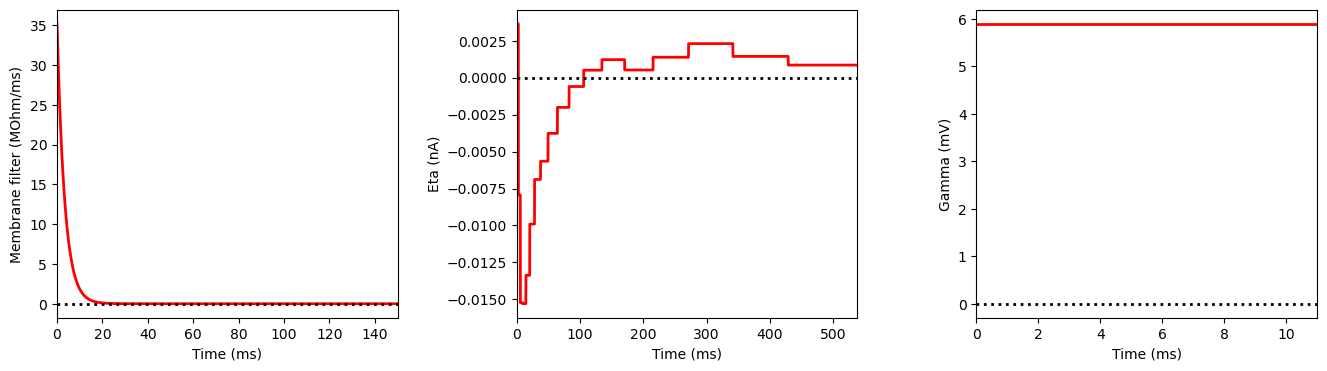

In [84]:
# Plot the model parameters
myGIF.printParameters()  
myGIF.plotParameters()   

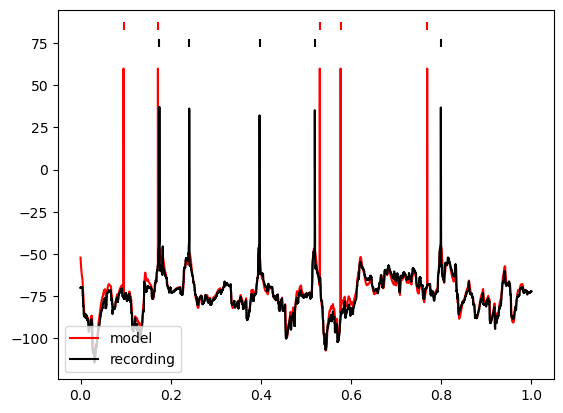

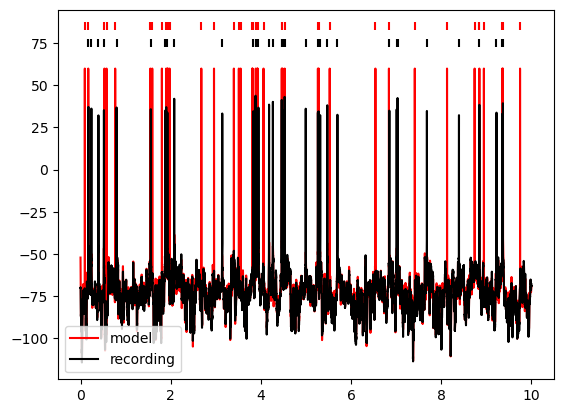

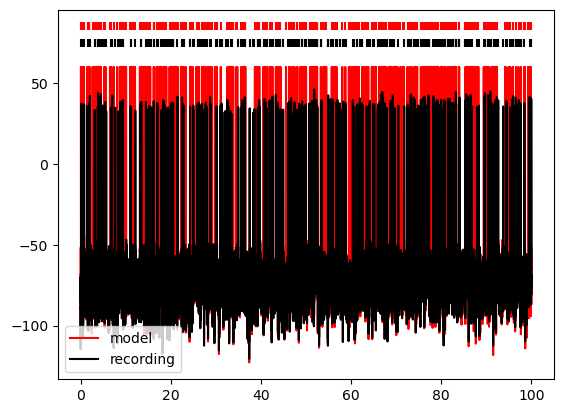

In [85]:

I = myExp.trainingset_traces[0].I
V_exp = myExp.trainingset_traces[0].V
spks = myExp.trainingset_traces[0].spks*myExp.dt
(time, V_model, I_a, V_t, S_model) = myGIF.simulate(I, myGIF.El)

time  = time/1000

def getBinarySpikeTrain(V,spikes,dt,type='zero'):
    spikeinds  = np.int32(spikes/dt)
    if type=='zero':
        b_spikes = np.zeros(len(V))

    else:
        b_spikes = np.zeros(len(V))*np.nan
    b_spikes[spikeinds] =1
    return b_spikes


spks_model = getBinarySpikeTrain(V_model,S_model,myExp.dt,type='nan')
spks_data = getBinarySpikeTrain(V_exp,spks,myExp.dt,type='nan')


plot_time = 1 # s
plt.plot(time[:plot_time*20000],V_model[:plot_time*20000],c='red',label='model')
plt.plot(time[:plot_time*20000],V_exp[:plot_time*20000],c='black',label='recording')
plt.scatter(time[:plot_time*20000], spks_model[:plot_time*20000]*85,c='red' ,marker='|')
plt.scatter(time[:plot_time*20000], spks_data[:plot_time*20000]*75,c='black',marker='|')
plt.legend(loc='lower left')
plt.show()



plot_time = 10 # s
plt.plot(time[:plot_time*20000],V_model[:plot_time*20000],c='red',label='model')
plt.plot(time[:plot_time*20000],V_exp[:plot_time*20000],c='black',label='recording')
plt.scatter(time[:plot_time*20000], spks_model[:plot_time*20000]*85,c='red' ,marker='|')
plt.scatter(time[:plot_time*20000], spks_data[:plot_time*20000]*75,c='black',marker='|')
plt.legend(loc='lower left')
plt.show()


plot_time = 100 # s
plt.plot(time[:plot_time*20000],V_model[:plot_time*20000],c='red',label='model')
plt.plot(time[:plot_time*20000],V_exp[:plot_time*20000],c='black',label='recording')
plt.scatter(time[:plot_time*20000], spks_model[:plot_time*20000]*85,c='red' ,marker='|')
plt.scatter(time[:plot_time*20000], spks_data[:plot_time*20000]*75,c='black',marker='|')
plt.legend(loc='lower left')
plt.ion=True
plt.show()
# plt.imshow()


In [86]:
len(S_model)

441

In [87]:
print(len(spks)/100)
print(len(S_model)/100)

4.34
4.41


In [91]:

get_gamma_factor(S_model,spks,20,100*1000,1/20,rate_correction=False)


0.2482270172760702